<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [1]:
!pip install torch==1.8.0 torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but 

In [2]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 856.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into acc

In [2]:
!nvidia-smi

Sat Apr  8 15:52:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

restart note

In [1]:
import pandas as pd
import numpy as np
import torch

from torchtext.legacy import datasets

from  torchtext.legacy.data import Field, LabelField
from torchtext.legacy.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [130]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [131]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [132]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части

In [133]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

## LSTM

In [138]:
class MyLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()     
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)      
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           dropout=dropout,
                           bidirectional=bidirectional,
                           )
        self.bidir = 2 if bidirectional else 1
        self.fc = nn.Linear(self.bidir*hidden_dim, output_dim)
        
        
    def forward(self, text, text_lengths):       
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidir == 2:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), 1)
        else:
            hidden = hidden[-1, :, :]
            
        return self.fc(hidden)

In [147]:
vocab_size = len(TEXT.vocab)
emb_dim = 64
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=3

In [148]:
lstm_bidir = MyLSTM(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

In [149]:
lstm_bidir = lstm_bidir.to(device)

In [150]:
opt = torch.optim.Adam(lstm_bidir.parameters())
loss_func = nn.BCEWithLogitsLoss()
max_grad_norm=3
max_epochs = 10

In [151]:
def train_model(model, train_iter, valid_iter, optimizer, loss, max_epochs, max_grad_norm):

    train_losses, valid_losses = [], []
    for epoch in range(max_epochs):
        train_loss = 0.0
        true_pred, count_pred = 0, 0
        model.train()
        pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=True)
        pbar.set_description(f"Epoch {epoch+1}")
        for it, batch in pbar:
            optimizer.zero_grad()
            seq, lengths = batch.text
            pred = model(seq, lengths.cpu())
            loss = loss_func(pred, batch.label.reshape(-1, 1))
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            train_loss += loss.item()
            optimizer.step()
            true_pred += (torch.sigmoid(pred) >= 0.5).sum().item()
            count_pred += pred.shape[0]

        train_acc = true_pred / count_pred
        train_loss /= len(train_iter)
        train_losses.append(train_loss)
  

        model.eval()
        val_loss = 0.0
        true_pred, count_pred = 0, 0
        pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=True)
        pbar.set_description(f"Epoch {epoch+1}")
        for it, batch in pbar:
            seq, lengths = batch.text
            pred = model(seq, lengths.cpu())
            loss = loss_func(pred, batch.label.reshape(-1, 1))
            val_loss += loss.item()
            true_pred += (torch.sigmoid(pred) >= 0.5).sum().item()
            count_pred += pred.shape[0]

        val_acc = true_pred / count_pred
        val_loss /= len(valid_iter)
        valid_losses.append(val_loss)
    return train_losses, valid_losses

In [152]:
train_losses, valid_losses = train_model(lstm_bidir,train_iter, valid_iter, opt, loss_func, max_epochs, max_grad_norm)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

In [31]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, valid_losses):
  plt.title("Losses per epochs")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.plot(train_losses, 'r')
  plt.plot(valid_losses, 'b')
  plt.legend(['Train', 'Valid'])




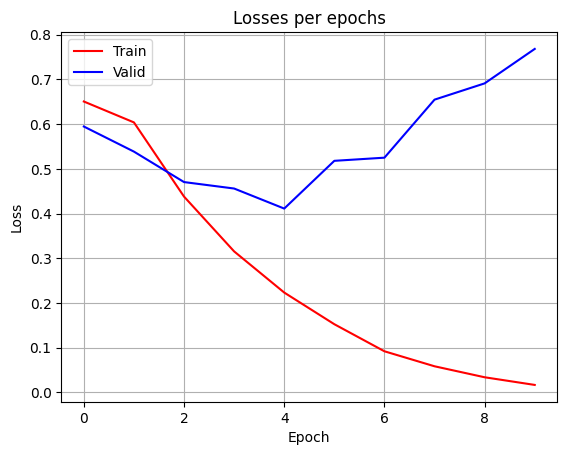

In [153]:
plot_losses(train_losses, valid_losses)

In [34]:
from sklearn.metrics import f1_score   
def calc_f1(model, test_iter):
    model.eval()
    test_pred = []
    test_true = [] 
    pbar = tqdm(enumerate(test_iter), total=len(test_iter), leave=False)
    for it, batch in pbar:
        # YOUR CODE GOES HERE
        seq, lengths = batch.text
        pred = model(seq, lengths.cpu())
        batch_test_pred = torch.sigmoid(pred).cpu().reshape(-1).tolist()
        batch_test_true = batch.label.cpu().tolist()
        test_pred.extend(batch_test_pred)
        test_true.extend(batch_test_true)

    return f1_score(np.array(test_true, dtype=int), np.array(test_pred) >= 0.5)

In [154]:
calc_f1(lstm_bidir, test_iter)

  0%|          | 0/391 [00:00<?, ?it/s]

0.8242636045931102

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [7]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [87]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        output_dim,
        dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.convolutions = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size= size) for size in kernel_sizes])     
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, output_dim)      
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convolutions]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(tuple(pooled), dim=1))
            
        return self.fc(cat)

In [106]:
kernel_sizes = [2, 3, 5]
vocab_size = len(TEXT.vocab)
out_channels = 128
dropout = 0.5
emb_dim = 300
output_dim = 1

cnn = CNN(vocab_size=vocab_size, emb_dim=emb_dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes,output_dim=output_dim, dropout=dropout)

In [107]:
cnn.to(device)

CNN(
  (embedding): Embedding(202243, 300)
  (convolutions): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=384, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [108]:
opt = torch.optim.AdamW(cnn.parameters())
loss_func = nn.BCEWithLogitsLoss()
max_grad_norm = 3

In [91]:
max_epochs = 10

In [109]:
def train_model(model, train_iter, val_iter, optimizer, loss, max_epochs, max_grad_norm):

    train_losses, valid_losses = [], []
    for epoch in range(max_epochs):
        train_loss = 0.0
        true_pred, count_pred = 0, 0
        model.train()
        pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=True)
        pbar.set_description(f"Epoch {epoch+1}")
        for it, batch in pbar:
            optimizer.zero_grad()
            seq = batch.text
            pred = model(seq)
            loss = loss_func(pred, batch.label.reshape(-1, 1))
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            train_loss += loss.item()
            optimizer.step()
            true_pred += (torch.sigmoid(pred) >= 0.5).sum().item()
            count_pred += pred.shape[0]

        train_acc = true_pred / count_pred
        train_loss /= len(train_iter)
        train_losses.append(train_loss)
  

        model.eval()
        val_loss = 0.0
        true_pred, count_pred = 0, 0
        pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=True)
        pbar.set_description(f"Epoch {epoch+1}")
        for it, batch in pbar:
            seq = batch.text
            pred = model(seq)
            loss = loss_func(pred, batch.label.reshape(-1, 1))
            val_loss += loss.item()
            true_pred += (torch.sigmoid(pred) >= 0.5).sum().item()
            count_pred += pred.shape[0]

        val_acc = true_pred / count_pred
        val_loss /= len(val_iter)
        valid_losses.append(val_loss)
    return train_losses, valid_losses

In [110]:
train_losses, valid_losses = train_model(cnn,train_iter, val_iter, opt, loss_func, max_epochs, max_grad_norm)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

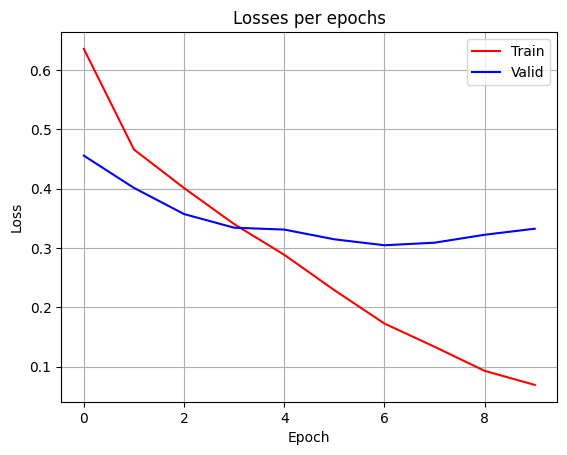

In [111]:
plot_losses(train_losses, valid_losses)

kernel_sizes = [3, 4, 5]

out_channels=64

emb_dim = 300

opt = Adam

max_grad = 2

f1 = 0.8264433608932231

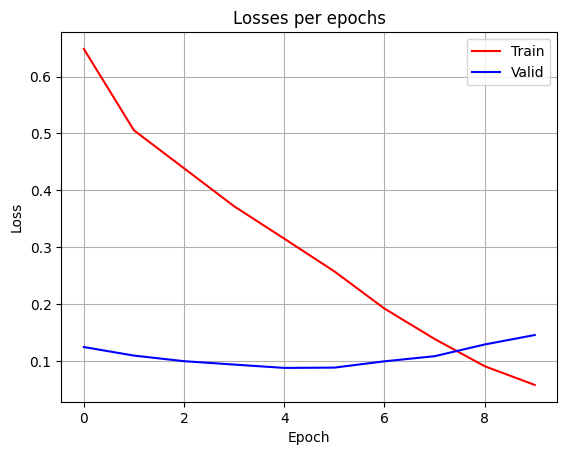




kernel_sizes = [2, 4, 6]

out_channels=64

emb_dim = 300

opt = AdamW

max_grad = 3

f1 = 0.8591669247445031


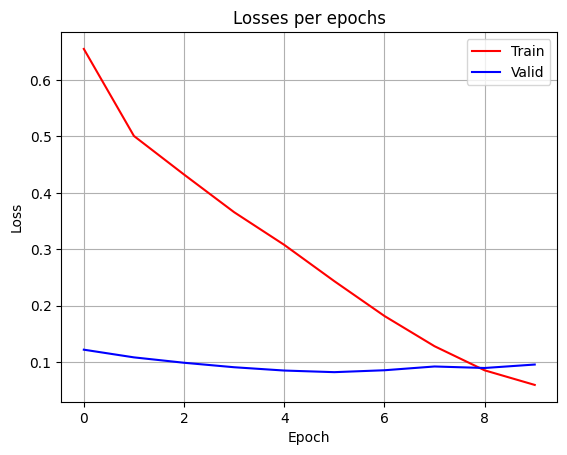

In [95]:
def calc_f1_cnn(model, test_iter):
    model.eval()
    test_pred = []
    test_true = [] 
    pbar = tqdm(enumerate(test_iter), total=len(test_iter), leave=False)
    for it, batch in pbar:
        seq= batch.text
        pred = model(seq)
        batch_test_pred = torch.sigmoid(pred).cpu().reshape(-1).tolist()
        batch_test_true = batch.label.cpu().tolist()
        test_pred.extend(batch_test_pred)
        test_true.extend(batch_test_true)

    return f1_score(np.array(test_true, dtype=int), np.array(test_pred) >= 0.5)

In [112]:
calc_f1_cnn(cnn, test_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

0.864730964467005

## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [113]:
!pip install -q captum

In [114]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(cnn, cnn.embedding)

In [115]:
def forward_with_softmax(model, inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(model, input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(model, input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [66]:
interpret_sentence(cnn, 'It was a fantastic performance !', label=1)
interpret_sentence(cnn, 'Best film ever', label=1)
interpret_sentence(cnn, 'Such a great show!', label=1)
interpret_sentence(cnn, 'It was a horrible movie', label=0)
interpret_sentence(cnn, 'I\'ve never watched something as bad', label=0)
interpret_sentence(cnn, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.86 ) , delta:  tensor([1.3299e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([1.3109e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.57 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.10 ) , delta:  tensor([6.7836e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.03 ) , delta:  tensor([2.9453e-05], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [67]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.86),pos,0.75,It was a fantastic performance ! pad
pos,neg (0.00),pos,0.34,Best film ever pad pad pad pad
pos,pos (0.57),pos,0.76,Such a great show! pad pad pad
neg,neg (0.01),pos,-0.84,It was a horrible movie pad pad
neg,neg (0.10),pos,-0.53,I've never watched something as bad pad
neg,neg (0.03),pos,-0.28,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.86),pos,0.75,It was a fantastic performance ! pad
pos,neg (0.00),pos,0.34,Best film ever pad pad pad pad
pos,pos (0.57),pos,0.76,Such a great show! pad pad pad
neg,neg (0.01),pos,-0.84,It was a horrible movie pad pad
neg,neg (0.10),pos,-0.53,I've never watched something as bad pad
neg,neg (0.03),pos,-0.28,It is a disgusting movie! pad pad


## Эмбеддинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [5]:
from torchtext.vocab import GloVe

In [18]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [65]:
TEXT.build_vocab(trn, vectors=GloVe())
LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
emb_dim = 300
output_dim = 1
out_channels=64

In [57]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

In [66]:
cnn_emb = CNN(vocab_size=vocab_size, emb_dim=emb_dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes,output_dim=output_dim, dropout=dropout)
word_embeddings = TEXT.vocab.vectors
prev_shape = cnn_emb.embedding.weight.shape
cnn_emb.embedding.weight = nn.Parameter(word_embeddings)
assert prev_shape == cnn_emb.embedding.weight.shape
cnn_emb.to(device)
opt = torch.optim.AdamW(cnn_emb.parameters())

In [67]:
freeze_embeddings(cnn_emb, req_grad=False)
opt = torch.optim.AdamW(cnn_emb.parameters())
loss_func = nn.BCEWithLogitsLoss()
max_grad_norm = 3
max_epochs = 10

In [68]:
train_losses, valid_losses = train_model(cnn_emb,train_iter, val_iter, opt, loss_func, max_epochs, max_grad_norm)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

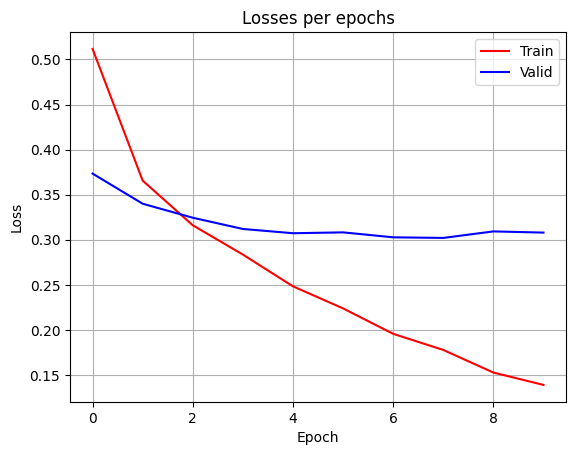

In [69]:
plot_losses(train_losses, valid_losses)

In [71]:
calc_f1_cnn(cnn_emb, test_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

0.8764127764127763

Проверим насколько все хорошо!

kernel_sizes = [2, 4, 6]

out_channels=64

emb_dim = 300

opt = AdamW

max_grad = 3

f1 = 0.8778647401163957

without embed learning


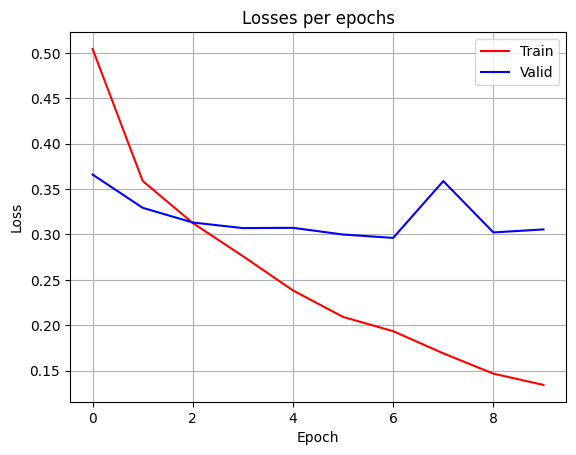

In [116]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(cnn_emb, cnn_emb.embedding)
vis_data_records_ig = []

interpret_sentence(cnn_emb, 'It was a fantastic performance !', label=1)
interpret_sentence(cnn_emb, 'Best film ever', label=1)
interpret_sentence(cnn_emb, 'Such a great show!', label=1)
interpret_sentence(cnn_emb, 'It was a horrible movie', label=0)
interpret_sentence(cnn_emb, 'I\'ve never watched something as bad', label=0)
interpret_sentence(cnn_emb, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.94 ) , delta:  tensor([7.4671e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.27 ) , delta:  tensor([2.4119e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.54 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([7.5029e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.38 ) , delta:  tensor([3.6913e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)


In [117]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.94),pos,1.59,It was a fantastic performance ! pad
pos,neg (0.27),pos,0.51,Best film ever pad pad pad pad
pos,pos (0.54),pos,1.07,Such a great show! pad pad pad
neg,neg (0.01),pos,-0.91,It was a horrible movie pad pad
neg,neg (0.38),pos,0.63,I've never watched something as bad pad
neg,neg (0.00),pos,-0.87,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.94),pos,1.59,It was a fantastic performance ! pad
pos,neg (0.27),pos,0.51,Best film ever pad pad pad pad
pos,pos (0.54),pos,1.07,Such a great show! pad pad pad
neg,neg (0.01),pos,-0.91,It was a horrible movie pad pad
neg,neg (0.38),pos,0.63,I've never watched something as bad pad
neg,neg (0.00),pos,-0.87,It is a disgusting movie! pad pad
